In [1]:
#필요한 패키지 임포트
import pandas as pd
import numpy as np
import librosa
from glob import glob
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

**비정형 데이터의 EDA**

In [2]:
#고양이 음성 파일 위치 불러오기
base_dir = '/catclass/augmented_data/unstructured_data/train/meow/'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp

파일의 확장자는 무엇인가?

In [10]:
#파일의 확장자 알아보기
print(train_path[0].split('.')[-1])

wav


파일의 길이, 샘플링 레이트는 무엇인가?

In [18]:
#파일의 길이, 샘플링 레이트 알아보기
print('length : '+str(librosa.get_duration(path='/catclass/-46xqouqMxA_6.wav'))+' sec')
print('sampling rate : '+str(librosa.get_samplerate(path='/catclass/-46xqouqMxA_6.wav'))+' kHz')

length : 9.170125 sec
sampling rate : 16000 kHz


파일의 음성 파형은 어떤 모양인가?

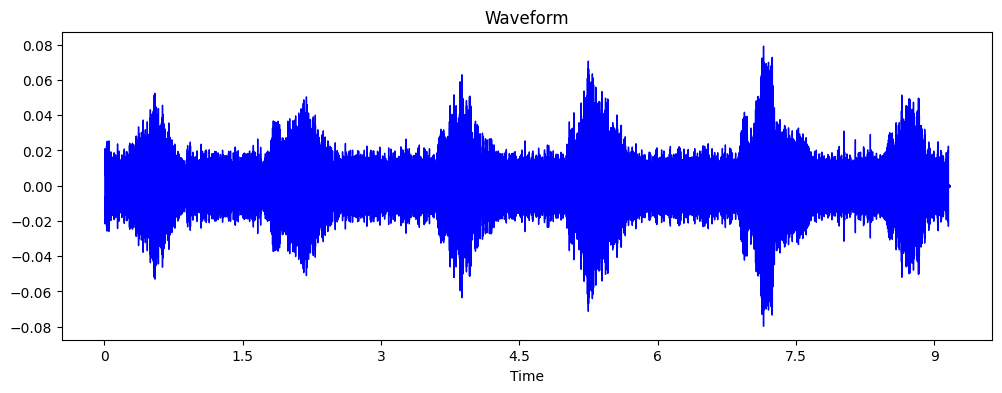

In [25]:
#원본 데이터의 파형
y,sr = librosa.load("/catclass/-46xqouqMxA_6.wav")
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr,  color="blue")
plt.title('Waveform')
plt.show()

원본 데이터의 Spectrogram은 무엇인가?

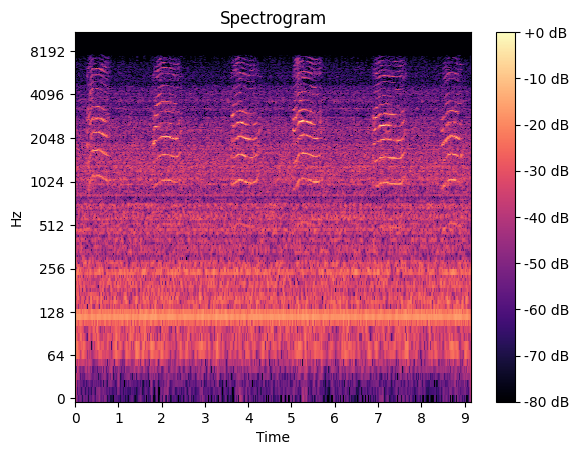

In [20]:
#원본 데이터의 Spectrogram
y, sr = librosa.load('/catclass/-46xqouqMxA_6.wav')
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

원본 데이터의 특징적인 값들은 무엇인가? (MFCC)

In [32]:
#mfcc 얻기
mfccs = librosa.feature.mfcc(y=y,sr=sr)
print(mfccs)

[[-405.77493   -383.97314   -386.87177   ... -397.99      -391.22617
  -404.2927   ]
 [ 156.04315    173.11053    180.70786   ...  165.21657    167.02975
   161.49443  ]
 [ -48.253227   -61.61284    -61.68759   ...  -72.13669    -73.36633
   -58.817764 ]
 ...
 [  -1.8358481   -2.9163232    2.3762558 ...    1.1091645   -4.3528214
    -5.0962105]
 [   1.9168429   -2.5084913   -6.9677377 ...  -10.139533    -7.806323
    -5.73901  ]
 [  -6.703021    -8.358321   -10.244764  ...   -1.7410345   -1.1825583
     3.2978601]]


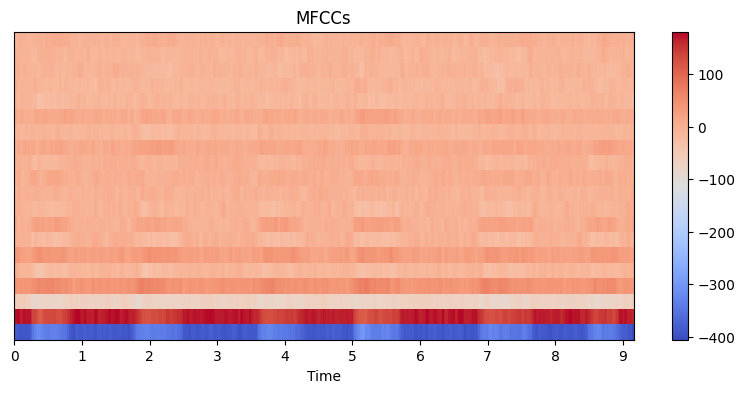

In [30]:
#mfcc 시각화하기
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.show()

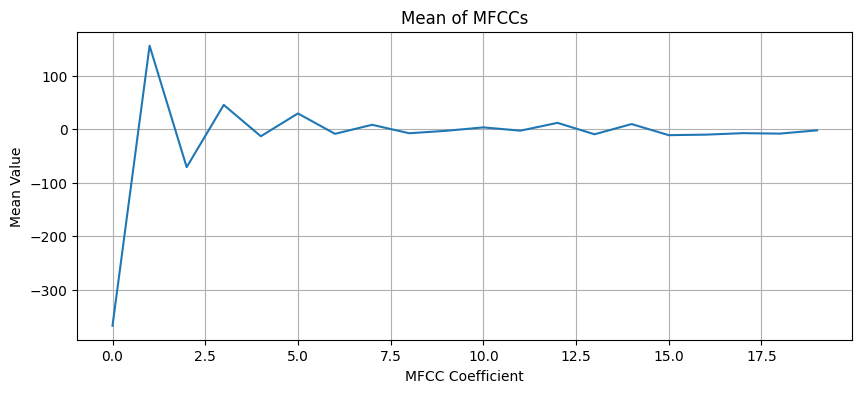

In [42]:
#mfcc의 평균을 구한 후 시각화한다
mean_mfccs = np.mean(mfccs, axis=1)
plt.figure(figsize=(10, 4))
plt.plot(mean_mfccs)
plt.xlabel('MFCC Coefficient')
plt.ylabel('Mean Value')
plt.title('Mean of MFCCs')
plt.grid(True)
plt.show()

<Axes: >

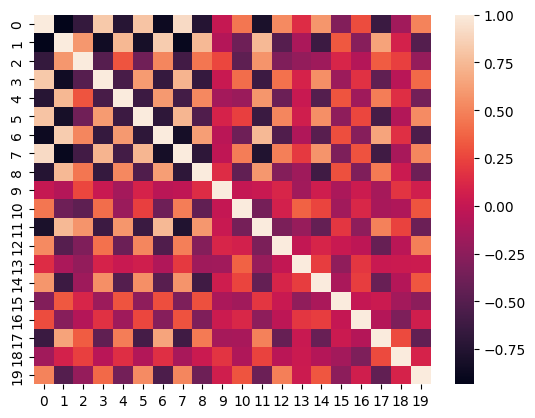

In [38]:
#mfcc의 corr 구하기
correlation_matrix = np.corrcoef(mfccs)
sns.heatmap(correlation_matrix)

데이터에게 영향을 주는 요인으로는 무엇이 있는가?

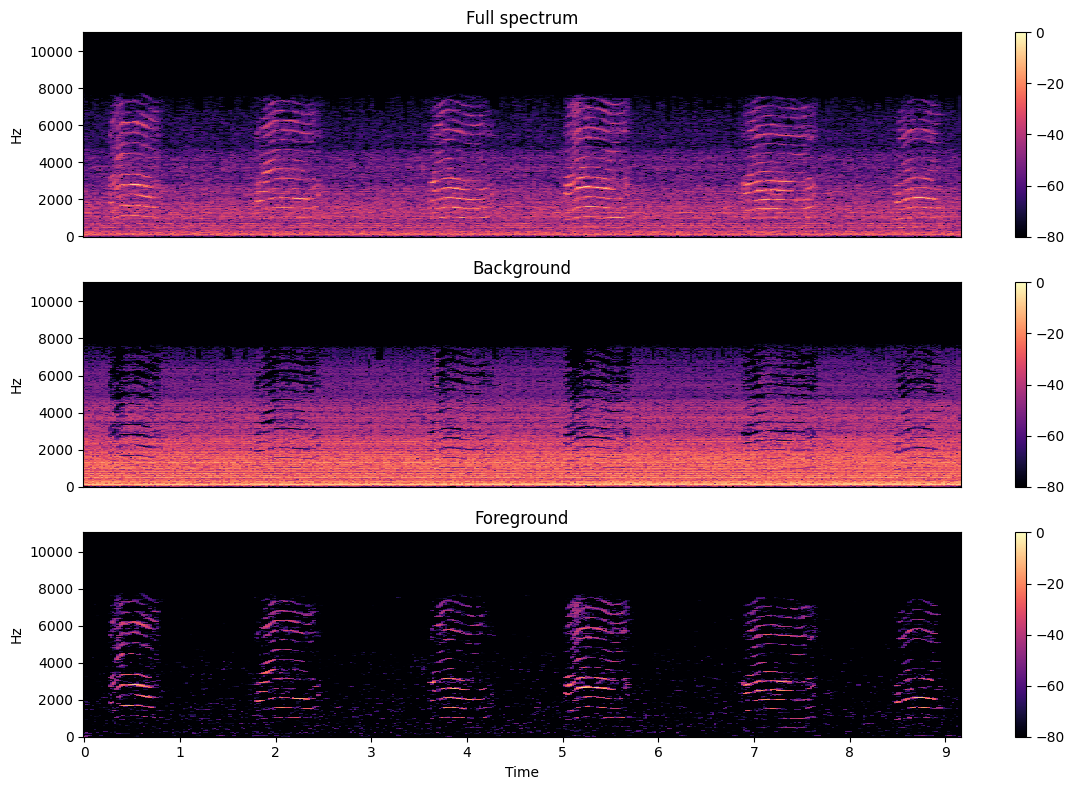

In [44]:
#데이터의 유의미한 음성과 배경 분리해 보기

S_full, phase = librosa.magphase(librosa.stft(y)) #speech processing에 n_fft=512 권장된다고는함



# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components
S_foreground = mask_v * S_full
S_background = mask_i * S_full
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='hz', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                         y_axis='hz', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='hz', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

배경 노이즈가 제거된 순수한 데이터를 얻어낼 수 있었다.

고양이 울음소리의 Spectrogram은 어떻게 생겼는지도 이를 통해 알아볼 수 있었다. 1.5초 미만의 길이로 나타나며, 직선이 여러 개 높은 주파수 영역대까지 쌓인 형태로 나타난다.

그렇다면 배경이 제거된 데이터에서 소리의 피크를 찾아 보면 어떻게 될까?


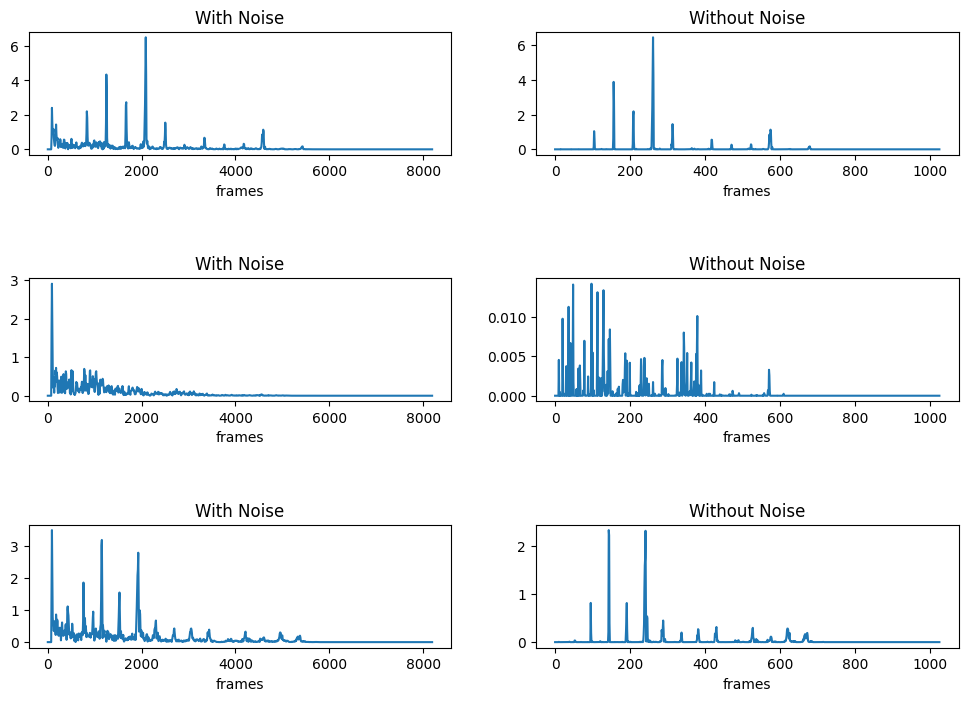

In [54]:
FREQ_MIN = 10

def get_timeslice(t, with_noise = False):
    S_arr=S_full if with_noise else S_foreground
    tslice=S_arr[:,librosa.time_to_frames(t,sr=sr)] #0보다 약간 큰 쪽에 피크 있음 -> 제거
    tslice[:FREQ_MIN] = 0
    return tslice

tlst = [0.5, 1.5, 5.5]

plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=1)
for i in range(len(tlst)): #모든 리스트 안의 시간에 대해
    t=tlst[i]
    plt.subplot(len(tlst),2,1+i*2)
    plt.title("With Noise")
    plt.xlabel("frames")
    plt.plot(np.linspace(0, 8192, 1025),get_timeslice(t, True)) #한 시간의 데이터를 플롯
    plt.subplot(len(tlst),2,2+i*2)
    plt.title("Without Noise")
    plt.xlabel("frames")
    plt.plot(get_timeslice(t, False)) #한 시간의 데이터를 플롯

Noise가 없으니 더 세밀하게 데이터를 바라볼 수 있다는 것을 알게 되었다.


sr은 sampling rate -> time & 열 인덱스 관계를 결정하고, frequncy & 행 인덱스 관계를 결정한다.

피크를 찾기 위해 필요한 것들은
1. 최소 Threshold. 적어도 1 넘는 값들만 볼 필요가 있음.
2. 노이즈 제거.


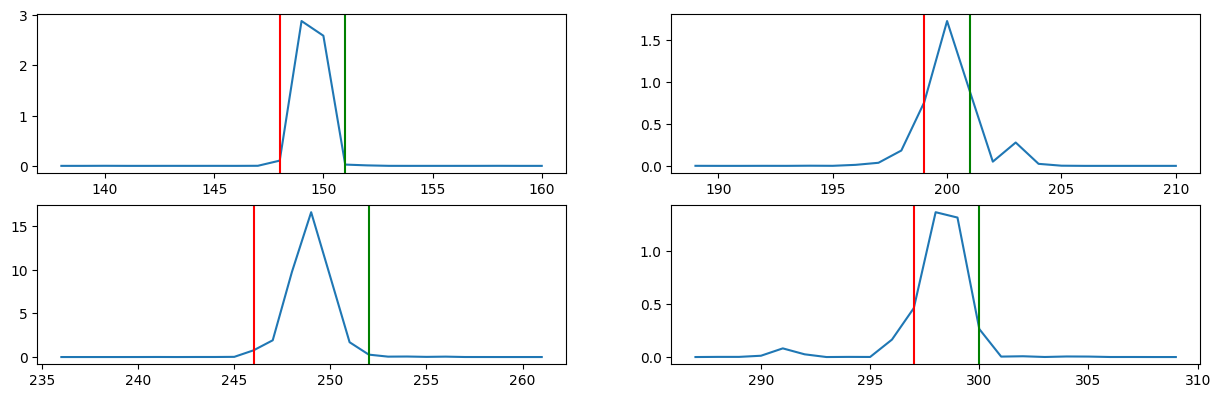

In [57]:
'''
전략: Threshold보다 작았다가 커지는거 탐지 & 커졌다가 작아지는거 탐지 -> 피크의 시작/끝 탐지해보자
numpy 함수들로 구현하는게 관건
'''
THRESHOLD = 1
PEAK_MAX_NUM = 5

def find_peaks(arr : np.ndarray): #진폭이 커지는 부분과 작아지는 부분을 찾아냄
    diff=np.diff(np.sign(arr-THRESHOLD))
    rising = np.where(diff==2)[0]
    rising = np.concatenate([rising, np.zeros(shape=(PEAK_MAX_NUM,))])[:PEAK_MAX_NUM]

    falling = np.where(diff==-2)[0]+1
    falling = np.concatenate([falling, np.zeros(shape=(PEAK_MAX_NUM,))])[:PEAK_MAX_NUM]

    return np.vstack([rising, falling])

tslice=get_timeslice(5.3)
peakarr = find_peaks(tslice).astype(int) #피크를 찾아서 저장

plt.figure(figsize=(15,12))
for i in range(peakarr.shape[1]): #찾아낸 모든 피크를 플롯함, 올라가는 부분을 빨간 선, 내려가는 부분을 초록 선으로 표시
    r,f = tuple(peakarr[:,i])
    if r==0:
        continue
    delta = 10
    plt.subplot(5,2,i+1)
    plt.plot(np.arange(r-delta,f+delta), tslice[r-delta:f+delta])
    plt.axvline(x=r, c='r')
    plt.axvline(x=f, c='g')
    

이제 피크를 찾을 수 있게 되었다.

피크에 대해 필요한 정보는 무엇이 있을까?
1) 위치
2) 너비? (이건 큰 의미 없을 듯. frequency 간격이 너무 넓기 때문)
3) 높이 
--> 위치와 높이만 필요

이 둘을 추출해 보자.

In [64]:
def ctft_to_peaks(carr : np.ndarray, threshold = 1, max_peak_num = 10): #ctft된 Spectrogram data에서 피크를 모두 찾는 함수
    rising = np.zeros(shape=(max_peak_num, carr.shape[1]))
    falling = np.zeros(shape=(max_peak_num , carr.shape[1]))
    diff=np.diff(np.sign(carr.T-threshold), axis = 1)

    for arr, num in [(rising, 2), (falling, -2)]: #올라가는 부분과 내려가는 부분을 찾음
        a,b = np.where(diff==num)
        for i in range(diff.shape[0]):
            temp=b[a==i]
            minlen = min(max_peak_num, len(temp))
            arr[:minlen,i]=temp[:minlen]

    return (rising, falling)

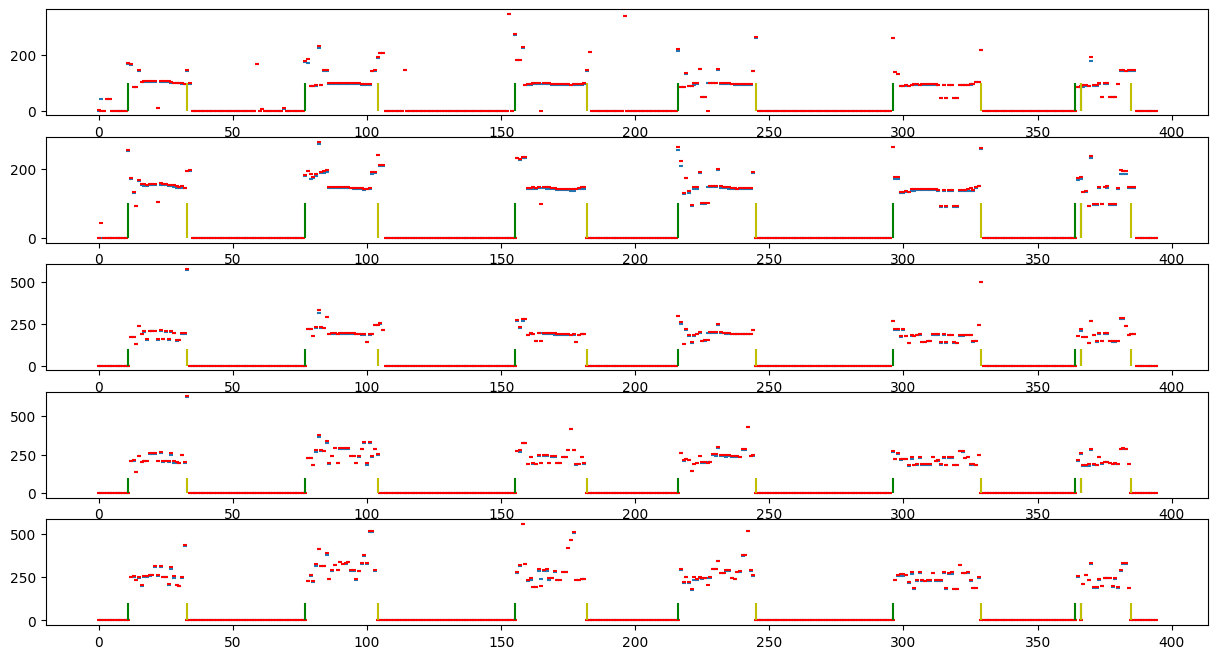

In [65]:
rising, falling = ctft_to_peaks(S_foreground, threshold=0.1, max_peak_num=5) #피크를 모두 찾은 뒤

x=np.arange(0, rising.shape[1],1/1).astype(int)
plt.figure(figsize=(15,8))

#의미있는 부분만 잘라내기
cnt_mat = (rising > 1e-5).sum(axis=0)
thres = 5 - 0.5
cutpoint_rising = np.where(np.diff(np.sign(cnt_mat-thres))==2)[0] #올라가는 점의 리스트
cutpoint_falling = np.where(np.diff(np.sign(cnt_mat-thres))==-2)[0]+1 #내려가는 점의 리스트
if(cnt_mat[0] > thres): #맨 앞 점 끼워넣기
    cutpoint_rising = np.insert(0,0,cutpoint_rising)

for i in range(5): #주파수 대역에 따라 다른 그래프로 시각화
    rising_2 = rising[i,:]
    falling_2 = falling[i,:]
    plt.subplot(5,1,i+1)
    plt.scatter(x[:], rising_2[:], s=10, marker='_')
    plt.scatter(x[:], falling_2[:], s=10, marker='_', c='r')
    plt.vlines(x=cutpoint_rising, ymin=0, ymax= 100,color='g')
    plt.vlines(x=cutpoint_falling, ymin=0, ymax= 100,color='y')

주파수별 피크를 모두 얻었다. 제대로 얻어졌는지 판단하기 위해 모든 주파수 영역대를 합쳐서 시각화해 보자.

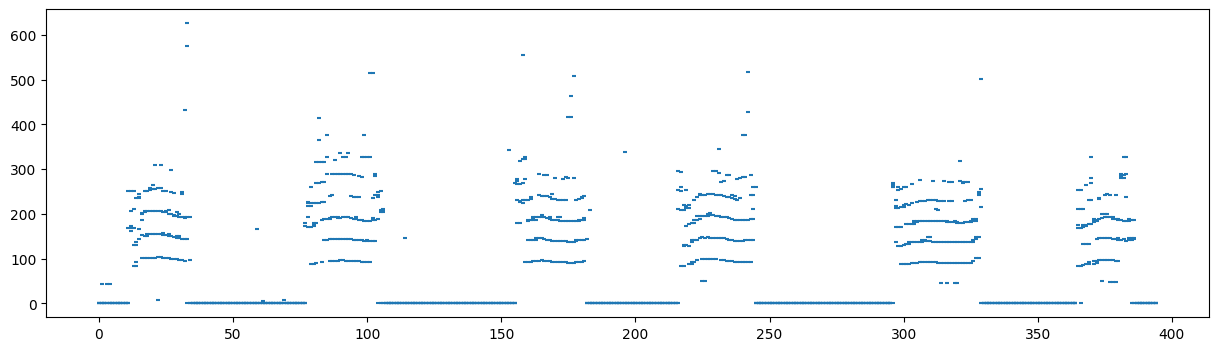

In [63]:
x=np.arange(0, rising.shape[1],0.2).astype(int)
plt.figure(figsize=(15,4))
plt.scatter(x, rising.T.flatten(), s=10, marker='_')

위에서 본 Spectrogram에서 깔끔하게 얻어진 피크들의 그래프를 볼 수 있다.

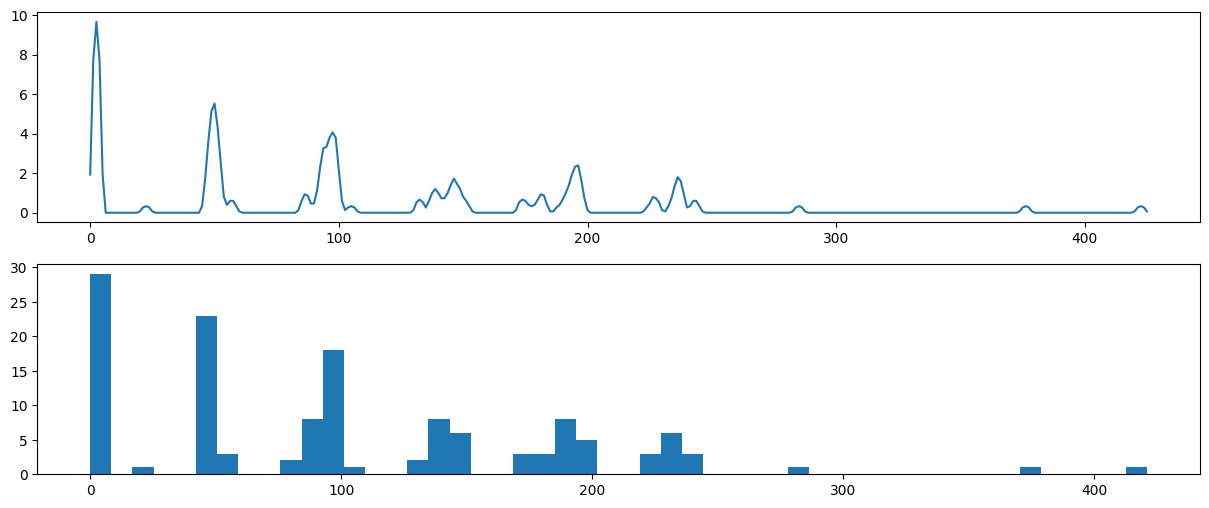

In [66]:
plt.figure(figsize=(15,6))

i=1
a,b=cutpoint_rising[i], cutpoint_falling[i]

#히스토그램처럼 각 frequency가 몇번씩 나왔는지 세줌.
scale = 0.8
new = rising[:,a:b]-np.min(rising[:,a:b],axis=0)
temp = (new.flatten() * scale).astype(int)
elem, counts = np.unique(temp, return_counts=True)
temp2 = np.zeros(shape = (np.max(elem)+1,))
temp2[elem] = counts

#매끄럽게
filter = np.array([1,4,5,4,1])
filter = filter / sum(filter)
temp2 = np.convolve(temp2, filter)

#앞에서 구한거 플롯
plt.subplot(2,1,1)
plt.plot(np.arange(np.max(elem)+1 + len(filter) - 1)/scale, temp2)
plt.subplot(2,1,2)
#비교용으로 히스토그램도 플롯. 둘이 대충 비슷하면 성공한거
plt.hist(new.flatten(), bins = 50)
plt.show()

이를 이용하면 각각의 주파수에 대한 피크 값도 추출할 수 있을 듯 하다.

**비정형 데이터에서 정형 데이터 추출**

위에서 본 MFCC 데이터를 비정형 데이터로부터 추출한다. (비정형 데이터와 다른 데이터셋)

In [2]:
#고양이 음성 파일 위치 불러오기
base_dir = '/catclass/augmented_data/structured_data/train/caterwaul/'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp

In [76]:
li = []
for i in range(len(train_path)):
    y,sr = librosa.load(train_path[i])
    mfccs = librosa.feature.mfcc(y=y,sr=sr)
    #mfcc의 평균을 구한 후 리스트에 어펜드
    mean_mfccs = np.mean(mfccs, axis=1)[1:]
    li.append(mean_mfccs)
    if i%100==0:
        print(i)
df = pd.DataFrame(li)
df.to_csv("/catclass/augmented_data/structured_data/train/meow/caterwaul.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600


**정형 데이터 EDA**

In [3]:
#dataframe 불러오기
df_meow = pd.read_csv("/catclass/augmented_data/structured_data/train/meow/meow.csv").iloc[:,1:]
df_caterwaul = pd.read_csv("/catclass/augmented_data/structured_data/train/caterwaul/caterwaul.csv").iloc[:,1:]

Meow, Caterwaul에 head, shape, info, describe, isna를 적용해 전반적인 데이터 형태의 파악을 해 보자.

In [14]:
df_meow.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,148.97668,-51.709938,75.362750,-47.673800,25.923391,-36.307580,10.871811,-15.230599,-3.411929,-1.713140,-10.433668,0.815263,-19.103000,4.101674,-4.231682,9.518656,-14.844532,8.433763,9.850194
1,171.46198,-44.638890,18.681830,26.157013,-22.517303,15.533758,22.504488,0.568935,6.506436,3.454565,10.232184,13.633137,-7.442061,2.969222,18.966692,5.879837,14.652749,19.062252,-2.040156
2,180.25370,-44.408940,41.582188,34.521080,24.515460,-24.470562,13.305822,21.454735,-5.628762,-0.679444,-7.189687,4.194264,-4.838626,12.780309,11.190937,0.245481,1.496121,-20.160686,-13.175027
3,199.35022,-103.836350,70.203200,33.758440,-27.126930,45.811085,6.588595,-4.489926,16.769041,-4.106375,13.885373,9.383706,-15.307931,3.808329,8.990068,-6.472169,-3.520761,5.240314,9.190849
4,216.35930,-61.750300,8.161021,39.758957,-27.103483,5.492200,17.222095,-11.504082,12.811937,14.190342,-3.081301,9.612517,0.279400,-6.427592,11.040759,4.211536,3.098168,16.241661,3.866039


In [10]:
df_meow.shape

(8681, 19)

In [5]:
df_meow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8681 entries, 0 to 8680
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       8681 non-null   float64
 1   1       8681 non-null   float64
 2   2       8681 non-null   float64
 3   3       8681 non-null   float64
 4   4       8681 non-null   float64
 5   5       8681 non-null   float64
 6   6       8681 non-null   float64
 7   7       8681 non-null   float64
 8   8       8681 non-null   float64
 9   9       8681 non-null   float64
 10  10      8681 non-null   float64
 11  11      8681 non-null   float64
 12  12      8681 non-null   float64
 13  13      8681 non-null   float64
 14  14      8681 non-null   float64
 15  15      8681 non-null   float64
 16  16      8681 non-null   float64
 17  17      8681 non-null   float64
 18  18      8681 non-null   float64
dtypes: float64(19)
memory usage: 1.3 MB


In [8]:
df_meow.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000
mean,176.410230,-69.932654,28.320945,8.316400,-8.839973,1.121343,12.705243,-7.968154,4.328496,1.246938,-4.329796,6.955136,-4.482944,1.863797,4.778590,4.737510,0.246220,5.466487,-0.037000
std,40.275268,29.548497,29.996615,26.311038,25.028477,18.423224,12.268588,10.425017,10.372888,9.065160,9.335366,9.127743,9.467317,8.574557,10.870094,8.197651,8.001727,8.393860,7.452332
min,-28.553198,-199.544450,-80.702270,-90.333640,-72.304450,-74.154350,-43.610460,-49.394608,-44.419384,-38.615845,-36.028600,-36.797490,-43.550137,-35.209290,-41.666320,-30.423592,-39.499146,-40.468880,-39.104580
25%,154.411740,-85.451060,9.105461,-9.639549,-27.873762,-11.770164,5.578515,-14.454002,-1.893598,-4.096895,-10.480704,1.594075,-10.479208,-3.468128,-2.391386,-0.591898,-4.468263,0.443758,-4.087538
50%,184.701640,-67.982850,27.428715,13.466567,-14.689854,4.916238,14.745817,-8.499935,5.456260,1.579532,-4.500747,7.743545,-4.070269,1.639055,5.776214,4.944362,0.681032,6.606595,0.310106
75%,204.301150,-54.189250,50.201653,29.976898,10.441035,13.975767,21.181032,-2.638418,10.757915,6.750549,1.101401,12.661027,1.629805,6.807671,12.835444,10.122531,5.330832,11.315249,4.407038
max,269.591580,93.306420,118.958725,69.425250,76.842600,60.315224,56.695923,47.289770,49.278250,58.239162,54.281860,46.234997,41.150124,49.358425,46.805153,45.572807,31.381664,30.288763,31.433311


In [18]:
df_meow.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

Meow 데이터에는 결측치가 없다.

In [15]:
df_caterwaul.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,205.39860,-103.69094,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687
1,205.39860,-103.69094,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687
2,139.87347,-79.66340,50.715355,-15.572526,27.152693,-21.569923,24.797922,9.945320,2.205587,10.388972,-14.062648,5.493455,-5.101165,11.707581,0.034978,5.181710,3.301609,4.938314,2.747216
3,207.49790,-77.59814,15.943235,44.663414,-29.027521,10.851999,23.504300,-3.599335,14.366628,5.164755,-6.008141,9.778302,-0.060158,1.245284,16.650180,6.365073,8.580484,17.264193,4.357121
4,199.11832,-43.01693,37.277138,9.707655,14.015252,-6.804242,17.587248,15.841443,1.096617,9.842384,-10.412914,1.263091,0.498261,6.876920,5.080964,1.015308,6.309715,3.709884,3.298363


In [11]:
df_caterwaul.shape

(10617, 19)

In [12]:
df_caterwaul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10617 entries, 0 to 10616
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10617 non-null  float64
 1   1       10617 non-null  float64
 2   2       10617 non-null  float64
 3   3       10617 non-null  float64
 4   4       10617 non-null  float64
 5   5       10617 non-null  float64
 6   6       10617 non-null  float64
 7   7       10617 non-null  float64
 8   8       10617 non-null  float64
 9   9       10617 non-null  float64
 10  10      10617 non-null  float64
 11  11      10617 non-null  float64
 12  12      10617 non-null  float64
 13  13      10617 non-null  float64
 14  14      10617 non-null  float64
 15  15      10617 non-null  float64
 16  16      10617 non-null  float64
 17  17      10617 non-null  float64
 18  18      10617 non-null  float64
dtypes: float64(19)
memory usage: 1.5 MB


In [13]:
df_caterwaul.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000
mean,199.337677,-72.206876,29.297736,20.482745,-6.434471,-1.158614,21.836596,4.396877,9.822247,7.874699,-9.138762,6.980390,-1.824104,4.331056,9.333566,3.762075,5.532161,11.073010,3.570528
std,28.524817,17.527221,22.253098,21.991516,21.918732,14.536647,5.496095,6.825837,9.085340,2.322983,6.363264,3.365832,3.286369,4.123829,6.017042,2.820191,2.004811,5.023684,1.406163
min,75.062480,-164.035980,-72.958570,-87.006010,-77.559840,-48.957165,-31.910177,-29.642048,-40.557762,-21.877466,-33.362007,-16.125591,-25.678268,-23.579681,-28.138666,-25.400688,-17.285740,-8.323215,-14.489716
25%,174.477540,-79.663400,6.207486,-2.212271,-29.027521,-12.634703,17.587248,-2.178029,1.096617,5.279308,-14.062648,5.035295,-5.101165,0.934714,3.334001,1.015308,4.014265,4.938314,2.922192
50%,205.398600,-73.962250,21.048964,22.068390,-19.779451,3.030261,23.504300,1.038503,6.083187,8.120633,-6.008141,7.142205,-1.974055,2.986375,9.824415,4.784276,5.591072,10.945308,3.053233
75%,215.593170,-58.785168,50.715355,37.130570,14.015252,10.922730,24.797922,9.736518,17.155128,9.389696,-2.484642,9.778302,0.498261,6.876920,12.330917,6.365073,6.309715,12.729613,4.357121
max,257.659360,21.929491,91.123870,61.413902,48.917010,33.481857,41.848240,30.193250,25.341300,27.695185,26.659452,26.834486,29.336283,24.825940,23.351357,22.478292,14.103569,20.399920,21.393280


In [17]:
df_caterwaul.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

Caterwaul 데이터에는 결측치가 없다.

Meow에 이상값이 있는가?

In [113]:
meow_arr = df_meow.__array__()
meow_arr.shape

(8681, 19)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb0c2ee3b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb0c2f0c100>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb0c2ee38e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb0c2f0c640>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb0c2f0c8e0>],
 'means': []}

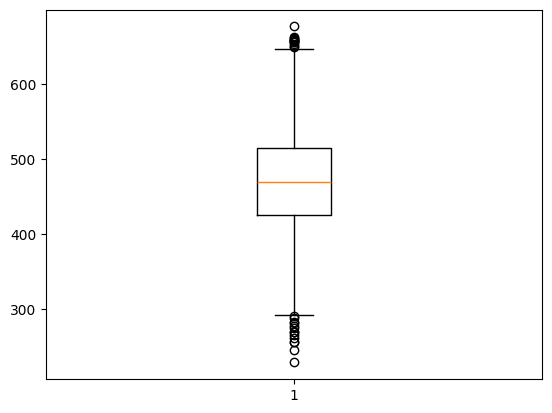

In [115]:
err_array = np.sum(np.abs(meow_arr - np.average(meow_arr)), axis = 1) #전체 값의 합에 대한 오차 (박스플롯)
plt.boxplot(err_array)

아웃라이어가 존재한다.

가장 오차가 큰 데이터는 무엇인가?

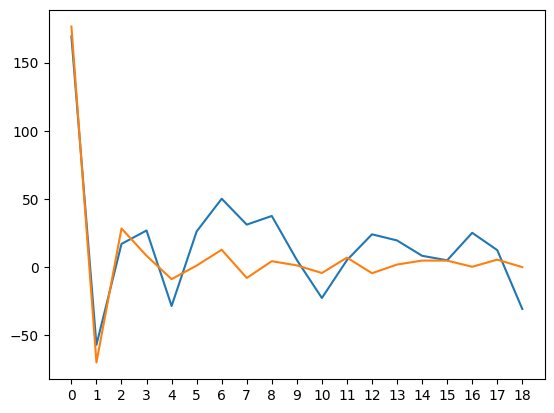

In [139]:
plt.plot(df_meow[np.sum(np.abs(stats.zscore(df_meow))>3, axis=1)>=6].iloc[0,:])
plt.plot(df_meow.mean())

결측치를 제외한 데이터를 찾는다.

In [149]:
df_meow_new = df_meow[(np.abs(stats.zscore(df_meow))<3).all(axis=1)]
df_meow_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,148.97668,-51.709938,75.362750,-47.673800,25.923391,-36.307580,10.871811,-15.230599,-3.411929,-1.713140,-10.433668,0.815263,-19.103000,4.101674,-4.231682,9.518656,-14.844532,8.433763,9.850194
1,171.46198,-44.638890,18.681830,26.157013,-22.517303,15.533758,22.504488,0.568935,6.506436,3.454565,10.232184,13.633137,-7.442061,2.969222,18.966692,5.879837,14.652749,19.062252,-2.040156
3,199.35022,-103.836350,70.203200,33.758440,-27.126930,45.811085,6.588595,-4.489926,16.769041,-4.106375,13.885373,9.383706,-15.307931,3.808329,8.990068,-6.472169,-3.520761,5.240314,9.190849
4,216.35930,-61.750300,8.161021,39.758957,-27.103483,5.492200,17.222095,-11.504082,12.811937,14.190342,-3.081301,9.612517,0.279400,-6.427592,11.040759,4.211536,3.098168,16.241661,3.866039
5,179.52351,-43.678974,25.193232,15.571154,-13.108270,4.003244,20.246320,-2.685353,0.770110,5.206519,3.727935,9.306947,-0.084326,4.249782,12.860862,13.191605,6.120707,11.786963,6.882188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8675,188.30191,-56.095238,13.957223,41.009335,-29.758284,2.758763,28.705975,-2.367443,3.194740,8.871480,2.233042,9.644005,2.135757,0.367714,11.628251,6.356226,12.325340,19.310324,-0.433715
8676,233.20152,-52.521473,29.728296,0.899056,-4.898423,8.941235,-23.673735,-5.866722,-1.745516,-7.313325,-15.231792,-10.937415,7.247839,-2.857565,1.451962,-0.941044,-9.842803,4.259428,4.674977
8677,79.22532,-88.770930,45.302624,-35.673800,18.549707,-19.377403,16.395504,-17.430038,-9.929862,-7.516968,-16.462860,-5.978959,-14.220096,15.215513,2.461714,9.923130,-10.644952,-6.772065,-6.731790
8678,164.25966,-71.923935,65.888210,-7.716682,9.085968,-12.579560,2.945799,-7.210678,-1.319161,-7.158673,-0.475821,-1.281677,-8.316510,1.153664,-6.097403,27.053493,-4.183150,3.853392,-0.536650


Caterwaul에 이상값이 있는가?

In [140]:
caterwaul_arr = df_meow.__array__()
caterwaul_arr.shape

(8681, 19)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb0c2717eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb0c2734430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb0c2717c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb0c2734970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb0c2734c10>],
 'means': []}

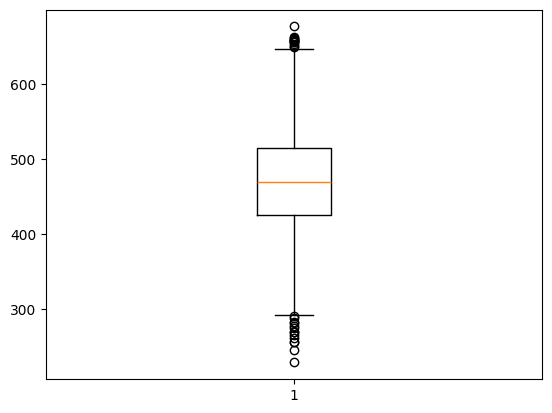

In [141]:
err_array = np.sum(np.abs(caterwaul_arr - np.average(caterwaul_arr)), axis = 1) #전체 값의 합에 대한 오차 (박스플롯)
plt.boxplot(err_array)

아웃라이어가 존재한다.

가장 오차가 큰 데이터는 무엇인가?

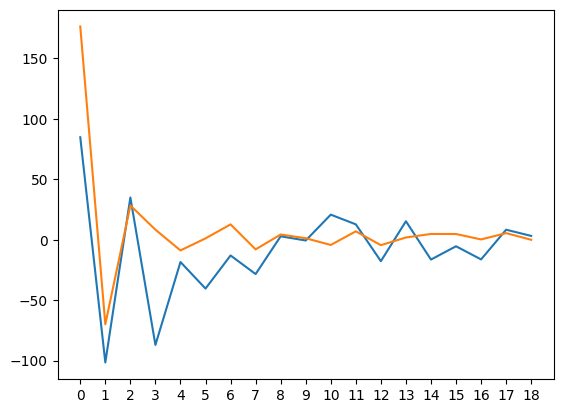

In [148]:
plt.plot(df_caterwaul[np.sum(np.abs(stats.zscore(df_caterwaul))>3, axis=1)>=10].iloc[0,:])
plt.plot(df_meow.mean())

결측치를 제외한 데이터를 찾는다.

In [150]:
df_caterwaul_new = df_caterwaul[(np.abs(stats.zscore(df_caterwaul))<3).all(axis=1)]
df_caterwaul_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,205.39860,-103.690940,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687
1,205.39860,-103.690940,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687
2,139.87347,-79.663400,50.715355,-15.572526,27.152693,-21.569923,24.797922,9.945320,2.205587,10.388972,-14.062648,5.493455,-5.101165,11.707581,0.034978,5.181710,3.301609,4.938314,2.747216
3,207.49790,-77.598140,15.943235,44.663414,-29.027521,10.851999,23.504300,-3.599335,14.366628,5.164755,-6.008141,9.778302,-0.060158,1.245284,16.650180,6.365073,8.580484,17.264193,4.357121
4,199.11832,-43.016930,37.277138,9.707655,14.015252,-6.804242,17.587248,15.841443,1.096617,9.842384,-10.412914,1.263091,0.498261,6.876920,5.080964,1.015308,6.309715,3.709884,3.298363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10612,207.49790,-77.598140,15.943235,44.663414,-29.027521,10.851999,23.504300,-3.599335,14.366628,5.164755,-6.008141,9.778302,-0.060158,1.245284,16.650180,6.365073,8.580484,17.264193,4.357121
10613,236.65007,-56.288265,1.272174,37.130570,-19.997023,11.484669,29.623394,9.736518,19.170862,9.360277,-2.484642,7.142205,-0.073727,0.934714,11.356770,2.400912,4.014265,12.446684,4.020939
10614,139.87347,-79.663400,50.715355,-15.572526,27.152693,-21.569923,24.797922,9.945320,2.205587,10.388972,-14.062648,5.493455,-5.101165,11.707581,0.034978,5.181710,3.301609,4.938314,2.747216
10615,205.39860,-103.690940,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687


데이터의 평균은 얼마나 다른가?

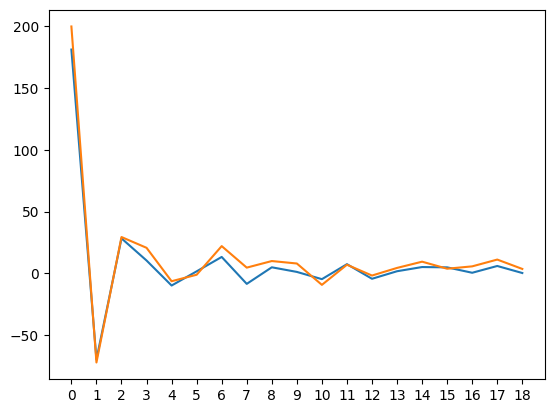

In [151]:
plt.plot(df_meow_new.mean())
plt.plot(df_caterwaul_new.mean())

특정 구간에서 차이가 나는 것을 파악할 수 있다. 10~20 정도의 유의미한 차이이다.

데이터의 표준편차는 어떤가?

In [153]:
df_meow_new.std()

0     36.094662
1     27.436700
2     28.986890
3     25.118593
4     24.688972
5     17.698446
6     11.123333
7      9.030552
8      9.149427
9      7.917719
10     8.284708
11     8.135482
12     8.597206
13     7.696897
14    10.317406
15     7.708125
16     7.218767
17     7.732733
18     6.502329
dtype: float64

In [154]:
df_caterwaul_new.std()

0     28.055789
1     16.841479
2     22.017637
3     21.833261
4     21.796983
5     14.459588
6      4.985561
7      6.436035
8      8.983452
9      1.872915
10     6.174457
11     3.171785
12     2.948910
13     3.946431
14     5.866709
15     2.585952
16     1.525617
17     4.949982
18     0.858030
dtype: float64

오차 막대를 포함해 그래프를 그려 보자.

<ErrorbarContainer object of 3 artists>

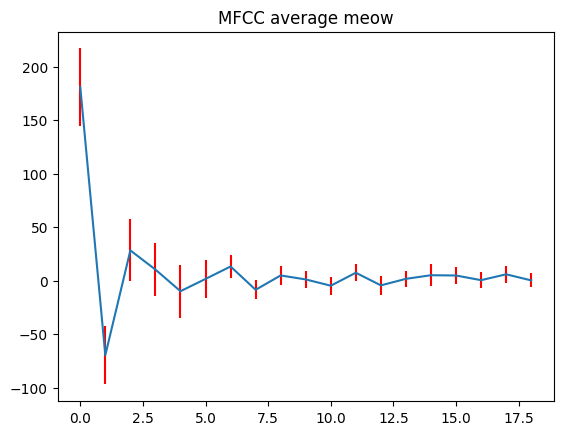

In [155]:
plt.title("MFCC average meow")
plt.errorbar(x=np.arange(19),y=df_meow_new.mean(), yerr=df_meow_new.std(),ecolor='r')

<ErrorbarContainer object of 3 artists>

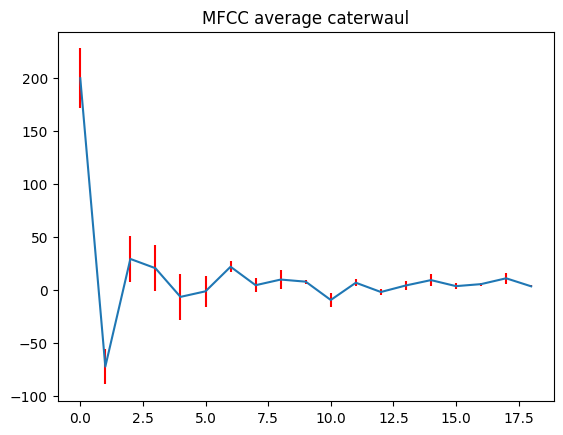

In [156]:
plt.title("MFCC average caterwaul")
plt.errorbar(x=np.arange(19),y=df_caterwaul_new.mean(), yerr=df_caterwaul_new.std(),ecolor='r')

MFCC의 표준편차가 뒤로 갈수록 작아지며, 앞부분에서도 크지 않은 것을 볼 수 있다.

MFCC의 평균의 상관계수는 어떻게 될까?

<Axes: >

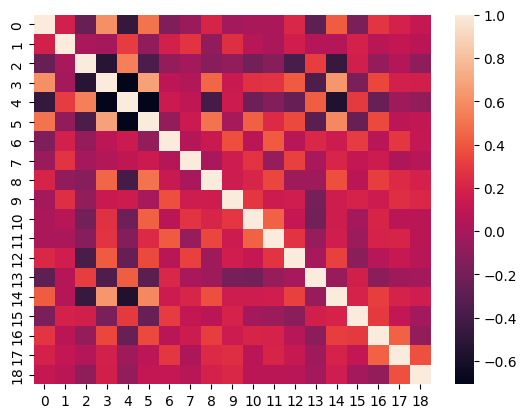

In [157]:
sns.heatmap(df_meow_new.corr())

<Axes: >

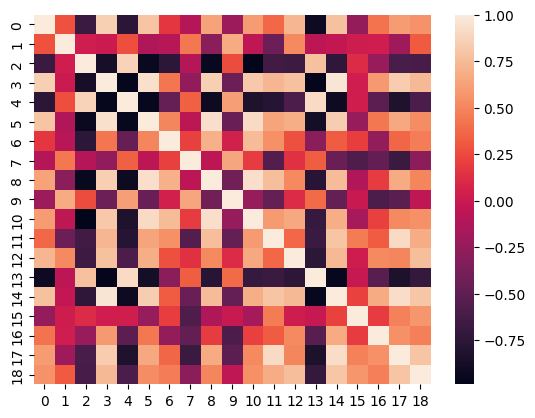

In [158]:
sns.heatmap(df_caterwaul_new.corr())

두 데이터의 양상이 확연히 다른 것을 볼 수 있다.

--------------------------


**인공지능 모델 구현 및 평가**

**1.CNN**

음성 데이터를 분류하기 위해 CNN을 사용했다. CNN의 입력으로 mel_spectrogram image로 변환된 음성 데이터가 사용된다.

In [1]:
#필요한 패키지 임포트
import pandas as pd
import numpy as np
import librosa
from glob import glob
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
import random
import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Conv2D, MaxPool2D, Flatten, Dense,SpatialDropout2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import *

2023-11-29 19:50:28.868877: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 19:50:28.869008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 19:50:28.870128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 19:50:28.878155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 19:50:29.661360: W tensorflow/compiler/tf2

In [14]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=160, n_mels=128, fmin=20, fmax=8300, top_db=80): #음성 파일의 mel_spectrogram을 얻는 함수
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<int(1.3*sr): #1.3초보다 짧을 시 패딩 진행
    wav=np.pad(wav,int(np.ceil((1.3*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:int(1.3*sr)]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [15]:
def spec_to_image(spec, eps=1e-6): #mel_spectrogram을 정규화해 이미지로 변환하는 함수
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [9]:
def showimg(imgarr): #이미지를 보여주는 함수
    plt.imshow(imgarr, vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    print(imgarr.shape)

In [10]:
def freq_masking(feat, F = 20, freq_mask_num = 2): #frequency에 랜덤으로 마스크를 씌우는 함수, 데이터 증강에 사용
    feat_size = feat.shape[1]
    seq_len = feat.shape[0]

    # freq mask
    for _ in range(freq_mask_num):
        f = np.random.uniform(low=0.0, high=F)
        f = int(f)
        f0 = random.randint(0, feat_size - f)
        feat[:, f0 : f0 + f] = 0

    return feat

In [11]:
def time_masking(feat, T = 70, time_mask_num = 2): #time에 랜덤으로 마스크를 씌우는 함수, 데이터 증강에 사용
    feat_size = feat.shape[1]
    seq_len = feat.shape[0]

    # time mask
    for _ in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=T)
        t = int(t)
        t0 = random.randint(0, seq_len - t)
        feat[t0 : t0 + t, :] = 0

    return feat

In [12]:
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '../catclass_ai/output/train/meow'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
meow_path = train_path

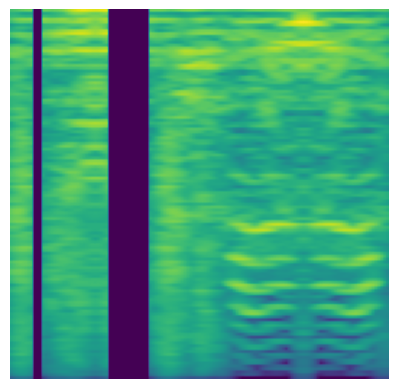

(128, 131)


In [13]:
showimg(freq_masking(spec_to_image(get_melspectrogram_db(str(meow_path[4]))))) #frequency masking이 된 예시

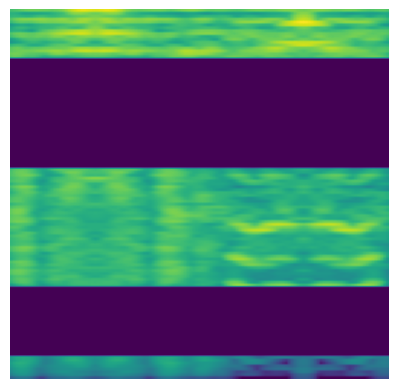

(128, 131)


In [14]:
showimg(time_masking(spec_to_image(get_melspectrogram_db(str(meow_path[4]))))) #time masking이 된 예시

In [ ]:
cnt=0 #모든 이미지에 대해, 위의 증강 함수를 거쳐 데이터 증강을 진행한다. 아래의 코드에는 train/meow 데이터만 증강하나, 이를 모든 데이터에 대해 시행하였다.
for i in range(len(meow_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(meow_path[i]))))
    im.save("/catclass_ai/img_aug/train/meow/"+str(cnt)+'.jpeg')
    cnt+=1
    for _ in range(5):
        im = Image.fromarray(freq_masking(spec_to_image(get_melspectrogram_db(str(meow_path[i])))))
        im.save("/catclass_ai/img_aug/train/meow/"+str(cnt)+'.jpeg')
        cnt+=1
    for _ in range(5):
        im = Image.fromarray(time_masking(spec_to_image(get_melspectrogram_db(str(meow_path[i])))))
        im.save("/catclass_ai/img_aug/train/meow/"+str(cnt)+'.jpeg')
        cnt+=1

In [2]:
train = ImageDataGenerator(rescale=1/255) #train 데이터셋 불러오기
train_dataset = train.flow_from_directory("../catclass_ai/img_aug/train/",
                                          target_size=(128,131),
                                          batch_size = 128,
                                          class_mode = 'binary',
                                          color_mode='grayscale')

Found 115851 images belonging to 2 classes.


In [16]:
# 테스트 데이터 생성하기
test = ImageDataGenerator(rescale=1/255) #test 데이터셋 불러오기

test_dataset = test.flow_from_directory("../catclass_ai/img_aug/val/",
                                          target_size=(128,131),
                                          batch_size =128,
                                          class_mode = 'binary',
                                          color_mode='grayscale')

Found 12906 images belonging to 2 classes.


In [17]:
train_dataset.class_indices

{'caterwaul': 0, 'meow': 1}

0.0


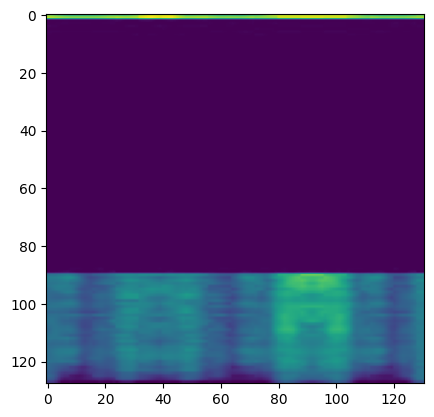

1.0


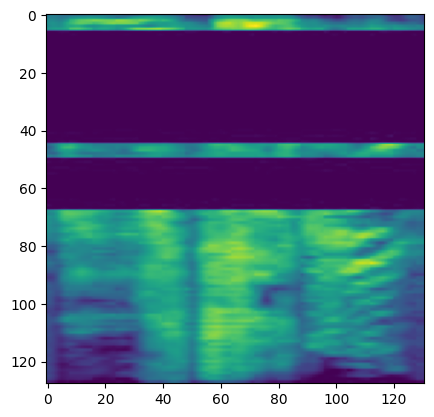

1.0


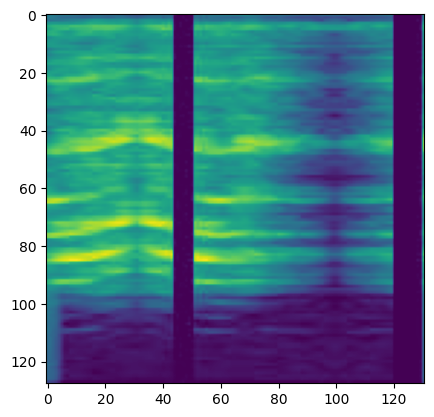

1.0


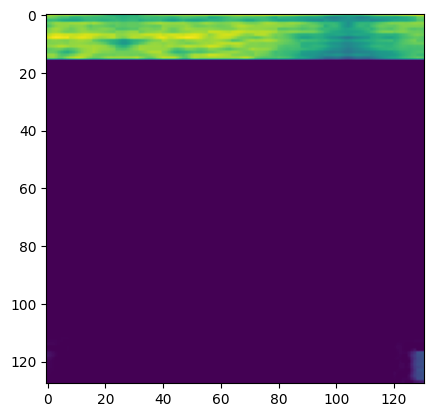

0.0


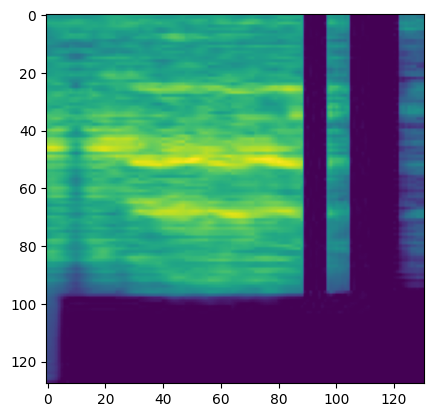

In [18]:
# 학습 데이터 레이블과 이미지 확인하기
for _ in range(5):
    img, label = train_dataset.next()
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [5]:
#모델 정의 : 여러 시행착오 과정 중 나온 가장 좋은 CNN 모델을 선정하였다.
model = Sequential()
model.add(Conv2D(128,(3,3),activation='relu',input_shape=(128,131,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(SpatialDropout2D(0.5))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(SpatialDropout2D(0.5))
model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

In [31]:
#모델 컴파일, loss로 sparse_categorical_crossentropy를 사용함
model.compile(optimizer = "adam" ,
              loss = "sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [32]:
#EarlyStopping 사용
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
# 모델 학습
# ModelCheckpoint 객체를 생성합니다.
checkpoint = ModelCheckpoint("../catclass_ai/aug_weights6.h5", monitor='val_loss', verbose=1, mode='auto', save_weights_only=True,save_best_only=True)

# 모델을 학습합니다. ModelCheckpoint 객체를 콜백으로 전달합니다.

history =  model.fit(train_dataset,
                     epochs=100,
                     batch_size=128,
                     verbose=1,
                     validation_data = test_dataset,
                     callbacks=[custom_early_stopping,checkpoint])

model.save('../catclass_ai/model_aug_softmax6.h5')

#모델의 훈련 기록을 csv로 저장 
hist_df = pd.DataFrame(history.history) 
hist_csv_file = '../catclass_ai/history6.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

훈련은 다른 파일에서 진행되었으며, 본 파일에서는 시간 관계상 훈련을 진행하지 않았다.

In [6]:
#훈련이 완료된 모델 불러오기
model = tf.keras.models.load_model('../catclass_ai/model_aug_softmax6.h5')

2023-11-29 19:51:05.827941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 19:51:05.884248: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 19:51:05.884321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 19:51:05.886503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 19:51:05.886579: I external/local_xla/xla/stream_executor

In [7]:
model.load_weights("../catclass_ai/aug_weights6.h5")

In [8]:
# 테스트 데이터 생성하기
test = ImageDataGenerator(rescale=1/255)
true_dataset = test.flow_from_directory("../catclass_ai/img_aug/val/",
                                          target_size=(128,131),
                                          batch_size =128,
                                          class_mode = 'binary')

Found 12906 images belonging to 2 classes.


In [20]:
# model.evaluate로 평가하기
score = model.evaluate(true_dataset, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 13ms/step - loss: 0.5462 - sparse_categorical_accuracy: 0.9038
Test loss: 0.5462260842323303
Test accuracy: 0.9038461446762085


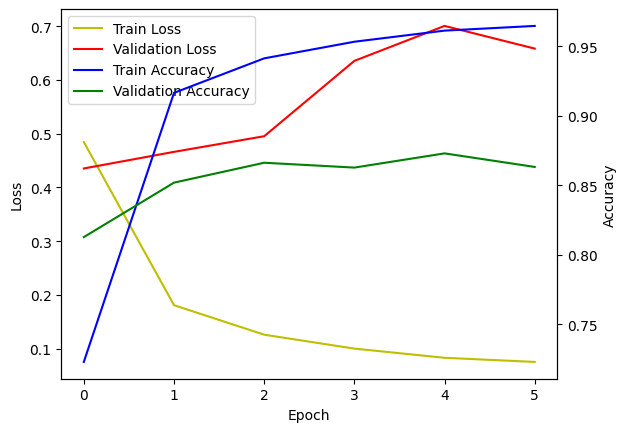

In [9]:
#훈련 과정 그래프 그리기
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = pd.read_csv("../catclass_ai/history6.csv")

# Plotting loss
loss_line1, = loss_ax.plot(hist['loss'], 'y', label='Train Loss')
loss_line2, = loss_ax.plot(hist['val_loss'], 'r', label='Validation Loss')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')

# Plotting accuracy
acc_line1, = acc_ax.plot(hist['sparse_categorical_accuracy'], 'b', label='Train Accuracy')
acc_line2, = acc_ax.plot(hist['val_sparse_categorical_accuracy'], 'g', label='Validation Accuracy')
acc_ax.set_ylabel('Accuracy')

# Creating a single legend
lines = [loss_line1, loss_line2, acc_line1, acc_line2]
labels = [line.get_label() for line in lines]
loss_ax.legend(lines, labels, loc='upper left')

plt.show()

In [10]:
#모델에 음성 파일을 mel_spectrogram_image로 변환한 뒤 주입해 예측 결과를 반환하는 함수
def model_test(filename):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(filename)))
    im.save("../catclass_ai/0.jpeg")
    img1 = load_img("../catclass_ai/0.jpeg",target_size=(128,131),color_mode='grayscale')
    #plt.imshow(img1)
    imarr = img_to_array(img1)
    X = np.expand_dims(imarr,axis=0)
    val = model.predict(X,verbose=0)
    return val

In [11]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '../catclass_ai/asdf/'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
test_caterwaul_path = train_path

In [12]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '../catclass_ai/augmented_data/test/meow/'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
test_meow_path = train_path

In [16]:
#훈련에 전혀 사용되지 않은 새로운 데이터를 가지고 오차 행렬과, 그를 통한 측정값 도출
li=[]
lili = []
for i in range(len(test_caterwaul_path)):
    a = model_test(test_caterwaul_path[i])
    lili.append(1)
    if a[0][0]>0:
        li.append(1)
    else:
        li.append(0)


for i in range(54):
    a = model_test(test_meow_path[i])
    lili.append(0)
    if a[0][0]>0:
        li.append(1)
    else:
        li.append(0)


confusion_matrix = confusion_matrix(lili,li)
print(confusion_matrix)
acc = accuracy_score(lili, li)
print('accuracy_score : ',acc)

pre = precision_score(lili, li)     
print('precision_score : ', pre)

recall = recall_score(lili, li)
print('recall_score: ', recall)

2023-11-29 19:51:34.983818: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905


[[39 15]
 [ 5 49]]
accuracy_score :  0.8148148148148148
precision_score :  0.765625
recall_score:  0.9074074074074074


CNN 모델 훈련 결과 accuracy 0.81, recall_score 0.91로 준수한 분류 성능을 보여주었다.

**2. DNN**

정형 데이터를 통한 인공지능을 만들기 위해 우선 DecisionTreeClassifier, RandomForestClassifier 모델을 시도해 보았고, 이후 DNN 모델을 시도하였다.

In [2]:
import pandas as pd
import numpy as np

In [114]:
#mean_mfcc dataframe 불러오기
meow_paths = ["./out_csv_denoise/train/meow.csv","./out_csv/val/meow.csv"]
caterwaul_paths = ["./out_csv_denoise/train/caterwaul.csv","./out_csv/val/caterwaul.csv"]
df_meow = pd.concat([pd.read_csv(path).iloc[:,1:] for path in meow_paths])
df_caterwaul = pd.concat([pd.read_csv(path).iloc[:,1:] for path in caterwaul_paths])

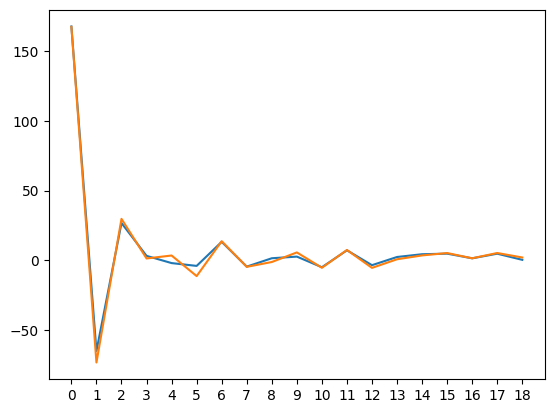

In [115]:
#평균적인 mfcc 분포 시각화. 크진 않지만 차이가 있음
import matplotlib.pyplot as plt
plt.plot(df_meow.mean())
plt.plot(df_caterwaul.mean())

In [179]:
#outlier 제외
from scipy import stats
df_caterwaul_new = df_caterwaul[(np.abs(stats.zscore(df_caterwaul))<2).all(axis=1)]
df_meow_new = df_meow[(np.abs(stats.zscore(df_meow))<2).all(axis=1)]
df_caterwaul_new['heat'] = 1
df_meow_new['heat'] = 0

C:\Users\leeyw\AppData\Local\Temp\ipykernel_10624\1662404033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_caterwaul_new['heat'] = 1
C:\Users\leeyw\AppData\Local\Temp\ipykernel_10624\1662404033.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meow_new['heat'] = 0


<ErrorbarContainer object of 3 artists>

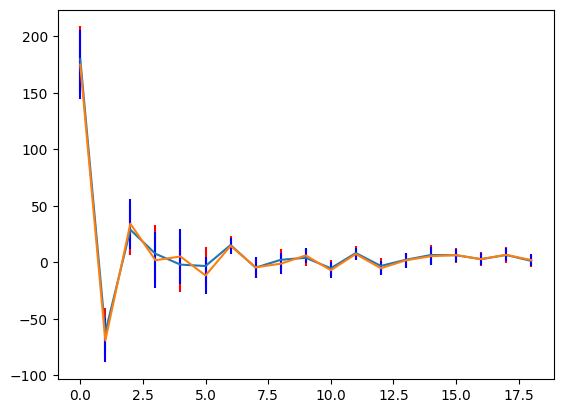

In [181]:
#표준편차 포함해서 그려보기. 오차에 비해 둘의 차이가 별로 크진 않음
plt.errorbar(x=np.arange(19),y=df_meow_new.mean()[:-1], yerr=df_meow_new.std()[:-1],ecolor='r')
plt.errorbar(x=np.arange(19),y=df_caterwaul_new.mean()[:-1], yerr=df_caterwaul_new.std()[:-1],ecolor='b')

In [182]:
#둘을 합친 전체 데이터 생성
data = pd.concat([df_caterwaul_new, df_meow_new], axis = 0)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,heat
1,148.71655,-56.059570,24.506561,7.429661,20.826944,-26.431847,22.104113,15.905318,-5.781409,17.948890,-3.478187,14.210629,-4.565736,2.778956,17.432985,6.384197,8.330157,4.074666,12.935174,1
2,163.16624,-73.653110,20.634079,-33.293600,16.910654,-22.839060,17.226694,-0.761105,-10.743077,10.497366,-9.850048,5.193643,-6.502373,9.618660,6.839106,7.642263,8.742185,5.522156,-0.249877,1
3,136.26277,-62.963250,5.627783,-38.267014,0.829553,-10.520046,18.422588,16.391607,4.115568,-0.138678,-22.390413,-0.661453,2.946633,1.864468,2.155122,10.299768,-6.726789,-8.523177,4.984896,1
4,148.28415,-62.626724,48.175667,-9.867022,24.423397,-13.748702,17.938587,5.569170,-1.344686,9.623691,-2.731928,10.742866,0.304746,6.297154,5.949749,11.946948,5.808087,9.513600,5.957467,1
6,147.61655,-82.886240,66.645280,-31.177149,23.261309,-24.079205,23.037620,-8.126665,-4.306679,-6.196653,-16.466599,7.649988,-4.628456,8.348021,-5.248707,9.782549,-5.102856,11.938311,1.859600,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,209.20123,-25.934029,8.200874,17.141113,-32.988335,3.831028,15.998309,-8.232378,9.833585,11.474479,2.726044,14.742446,3.732203,-3.500227,8.303271,0.338550,0.730458,12.029229,4.024381,0
57,198.26510,-73.947914,6.587902,37.434868,-25.810066,10.708785,17.715424,-7.981904,14.467289,4.346647,-5.790924,17.146843,1.260512,-4.354381,20.048640,7.505583,0.155295,15.204498,6.916534,0
58,195.74821,-69.527720,60.588154,14.276167,1.462735,-17.841160,14.337609,-15.081779,4.768477,0.450375,-16.862354,2.882443,-12.267480,3.500719,-0.306058,1.881312,-1.811612,11.765247,-2.124275,0
59,207.57375,-73.684660,4.139500,39.832104,-20.066920,8.521950,19.873455,-13.566601,4.289917,10.471521,5.251410,16.458982,-1.579123,-4.314270,17.311424,8.790894,0.695305,8.870236,1.478044,0


In [183]:
#피쳐와 레이블로 분리
x = data.iloc[:, :data.shape[1]-2]
y = data.iloc[:, data.shape[1]-1]

In [185]:
#train과 test데이터로 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 156, stratify=y)

In [187]:
#DNN 이전에 디시젼트리를 시도해봄
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classification
dt1 = DecisionTreeClassifier()

dt1.fit(x_train, y_train)
dt1_prediction = dt1.predict(x_test)

In [188]:
#정확도 64%. 기대에 비해 엄청 나쁘진 않음
from sklearn.metrics import accuracy_score

accuracy_score(y_test, dt1_prediction)

0.6338797814207651

In [189]:
#랜덤포레스트로도 한번 시도해봄. 디시젼 트리랑 큰 차이는 없음
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train , y_train)
rf_prediction = rf.predict(x_test)

print('오차 행렬\n', confusion_matrix(y_test, rf_prediction))
print('\n평가 지표\n', classification_report(y_test, rf_prediction))

오차 행렬
 [[90 19]
 [40 34]]

평가 지표
               precision    recall  f1-score   support

           0       0.69      0.83      0.75       109
           1       0.64      0.46      0.54        74

    accuracy                           0.68       183
   macro avg       0.67      0.64      0.64       183
weighted avg       0.67      0.68      0.67       183



In [190]:
#Scaling 수행해봄
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [192]:
#model의 history를 그려주는 modelplot 함수 정의
import matplotlib.pyplot as plt
def modelplot(history):
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(history.history['loss'], color='blue')
  ax[0].plot(history.history['val_loss'], color='orange')
  ax[0].set_title('Loss over Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'test'])

  ax[1].plot(history.history['accuracy'], color='blue')
  ax[1].plot(history.history['val_accuracy'], color='orange')
  ax[1].set_title('Accuracy over Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'test'])

  plt.tight_layout()
  plt.show()

In [193]:
#얼리스토핑 정의
from keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

In [197]:
#DNN 모델 구성.
from keras.layers import Dropout

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from glob import glob
# 앞에서 단순 layer보다는 노드가 많은 것이 더 좋은 성능을 보였기 때문에 노드를 늘려서 시험
# earlystopping만 적용하여 시험

NB_EPOCHS = 50
BATCH_SIZE = 32

model2 = Sequential()

model2.add(Dense(1024, input_dim=x_train.shape[1], kernel_initializer='random_normal', activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, kernel_initializer='random_normal', activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, kernel_initializer='random_normal', activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [198]:
# model1: 모델 학습 및 history 저장
history2 = model2.fit(X_train_scaled, y_train,
                     validation_data=(X_test_scaled, y_test),
                     epochs=NB_EPOCHS, batch_size=BATCH_SIZE,
                     verbose=1,
                     callbacks=[custom_early_stopping])
                     

Epoch 1/50
23/23 [==============================] - 1s 10ms/step - loss: 0.6604 - accuracy: 0.5920 - val_loss: 0.6479 - val_accuracy: 0.6339
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 0.6124 - accuracy: 0.6676 - val_loss: 0.6015 - val_accuracy: 0.6940
Epoch 3/50
23/23 [==============================] - 0s 5ms/step - loss: 0.5869 - accuracy: 0.6896 - val_loss: 0.5796 - val_accuracy: 0.6995
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5867 - accuracy: 0.6937 - val_loss: 0.5817 - val_accuracy: 0.6995
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5682 - accuracy: 0.7225 - val_loss: 0.5777 - val_accuracy: 0.6776
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 0.5435 - accuracy: 0.7541 - val_loss: 0.5697 - val_accuracy: 0.6776
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 0.5178 - accuracy: 0.7418 - val_loss: 0.5799 - val_accuracy: 0.6776
Epoch 8/50
23/23 [=

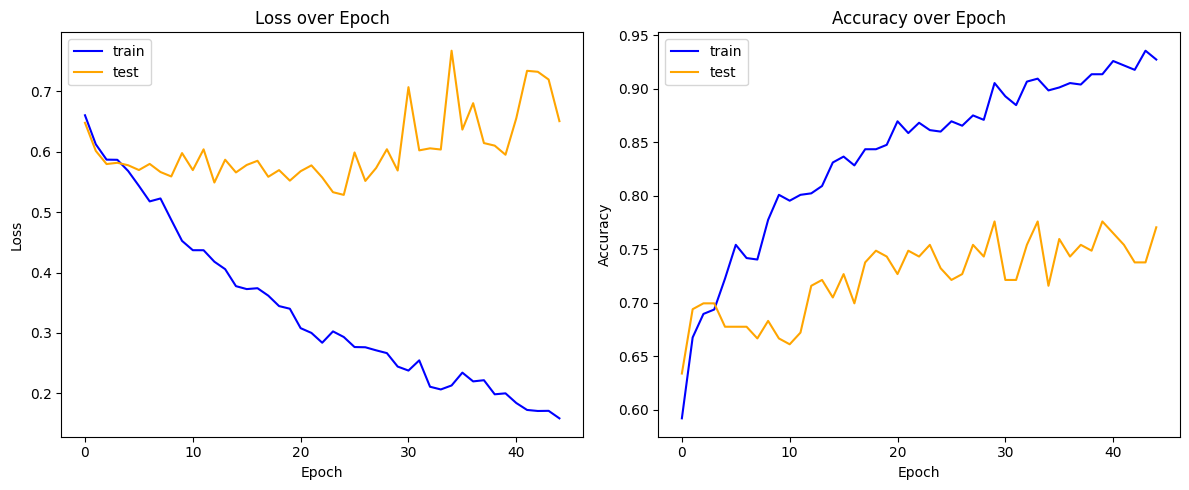

6/6 [==============================] - 0s 2ms/step - loss: 0.5286 - accuracy: 0.7322
Test loss: 0.528594970703125
Test accuracy: 0.7322404384613037


In [199]:
#이것저것 다 해본 결과 val_accuracy가 0.75를 돌파하기 매우 힘들었음. 평균화된 mfcc 데이터의 본질적인 한계를 느끼고 LSTM을 만들어봐야겠다고 생각함
modelplot(history2)

score2 = model2.evaluate(x=X_test_scaled, y=y_test, verbose=1)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

In [200]:
#모델 저장
model2.save('dnn_model.h5')

c:\Users\leeyw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


DNN의 한계로 인해 LSTM을 시도하게 되었다.

**3.LSTM**

In [86]:
import numpy as np
import pandas as pd

In [ ]:
#전처리된 RNN용 데이터 불러오기
path = './out_csv_denoise_rnn/train/meow.csv'
train_meow_data = np.reshape(pd.read_csv(path).iloc[:,1:].__array__().flatten(), (-1,13,64))
path = './out_csv_denoise_rnn/train/caterwaul.csv'
train_caterwaul_data = np.reshape(pd.read_csv(path).iloc[:,1:].__array__().flatten(), (-1,13,64))
path = './out_csv_denoise_rnn/val/meow.csv'
test_meow_data = np.reshape(pd.read_csv(path).iloc[:,1:].__array__().flatten(), (-1,13,64))
path = './out_csv_denoise_rnn/val/caterwaul.csv'
test_caterwaul_data = np.reshape(pd.read_csv(path).iloc[:,1:].__array__().flatten(), (-1,13,64))

In [89]:
#train/val data 생성
X_train = np.concatenate([train_meow_data, train_caterwaul_data])
Y_train = np.concatenate([np.zeros(train_meow_data.shape[0]), np.ones(train_caterwaul_data.shape[0])])

X_test = np.concatenate([test_meow_data, test_caterwaul_data])
Y_test = np.concatenate([np.zeros(test_meow_data.shape[0]), np.ones(test_caterwaul_data.shape[0])])

In [172]:
#unit size(hidden state 차원)을 64 -> 256으로 바꾸었더니 성능이 많이 좋아짐 
from keras.models import Sequential
from keras.layers import Dense, LSTM

# LSTM 모델 정의하기
model = Sequential()
# model.add(SimpleRNN(rnn_out, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, input_shape=(13, 64)))
# model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 256)               328704    
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 328961 (1.25 MB)
Trainable params: 328961 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [173]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_test, Y_test),
                    epochs = 18, batch_size=32, verbose = 1)

Epoch 1/18


44/44 [==============================] - 6s 47ms/step - loss: 0.6568 - accuracy: 0.6240 - val_loss: 0.6342 - val_accuracy: 0.6410
Epoch 2/18
44/44 [==============================] - 2s 37ms/step - loss: 0.5726 - accuracy: 0.6926 - val_loss: 0.6099 - val_accuracy: 0.6538
Epoch 3/18
44/44 [==============================] - 2s 38ms/step - loss: 0.5295 - accuracy: 0.7534 - val_loss: 0.5921 - val_accuracy: 0.6923
Epoch 4/18
44/44 [==============================] - 2s 41ms/step - loss: 0.4952 - accuracy: 0.7570 - val_loss: 0.5840 - val_accuracy: 0.6667
Epoch 5/18
44/44 [==============================] - 2s 54ms/step - loss: 0.4638 - accuracy: 0.7891 - val_loss: 0.5949 - val_accuracy: 0.6603
Epoch 6/18
44/44 [==============================] - 2s 49ms/step - loss: 0.4315 - accuracy: 0.8056 - val_loss: 0.5528 - val_accuracy: 0.7308
Epoch 7/18
44/44 [==============================] - 2s 49ms/step - loss: 0.3941 - accuracy: 0.8335 - val_loss: 0.5726 - val_accuracy: 0.6987
Epoch 8/18
44/44 [======

In [174]:
model.evaluate(X_test, Y_test)

1/5 [=====>........................] - ETA: 0s - loss: 0.8514 - accuracy: 0.7500

5/5 [==============================] - 0s 15ms/step - loss: 0.6378 - accuracy: 0.7628


[0.6377910375595093, 0.7628205418586731]

In [175]:
#아까 정의한 test data는 사실 validation data. 진짜로 test에 사용할 데이터 불러오기
path = './out_csv_denoise_rnn/test/meow_test.csv'
real_test_meow_data = np.reshape(pd.read_csv(path).iloc[:,1:].__array__().flatten(), (-1,13,64))[:54,:,:]
path = './out_csv_denoise_rnn/test/caterwaul_test.csv'
real_test_caterwaul_data = np.reshape(pd.read_csv(path).iloc[:,1:].__array__().flatten(), (-1,13,64))

In [176]:
#둘이 합쳐서 test 데이터 생성
X_realtest = np.concatenate([real_test_meow_data, real_test_caterwaul_data])
Y_realtest = np.concatenate([np.zeros(real_test_meow_data.shape[0]), np.ones(real_test_caterwaul_data.shape[0])])

In [184]:
#정확도 확인
model.evaluate(real_test_caterwaul_data, np.ones(real_test_caterwaul_data.shape[0]))

2/2 [==============================] - 0s 7ms/step - loss: 0.4917 - accuracy: 0.8333


[0.4916552007198334, 0.8333333134651184]

In [ ]:
#모델 저장
model.save('rnn_model.h5')

In [166]:
#model history를 csv로 저장
hist_df = pd.DataFrame(history.history) 
hist_csv_file = './history11.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

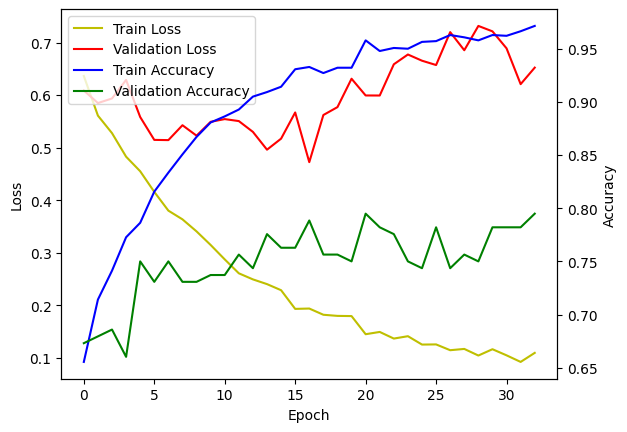

In [167]:
#저장한 csv를 플롯
import matplotlib.pyplot as plt
import pandas as pd

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = pd.read_csv("./history11.csv")

# Plotting loss
loss_line1, = loss_ax.plot(hist['loss'], 'y', label='Train Loss')
loss_line2, = loss_ax.plot(hist['val_loss'], 'r', label='Validation Loss')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')

# Plotting accuracy
acc_line1, = acc_ax.plot(hist['accuracy'], 'b', label='Train Accuracy')
acc_line2, = acc_ax.plot(hist['val_accuracy'], 'g', label='Validation Accuracy')
acc_ax.set_ylabel('Accuracy')

# Creating a single legend
lines = [loss_line1, loss_line2, acc_line1, acc_line2]
labels = [line.get_label() for line in lines]
loss_ax.legend(lines, labels, loc='upper left')

plt.show()

In [186]:
#(real)test data의 예측값 array
y_pred = model.predict(X_realtest).round().astype(int)

4/4 [==============================] - 0s 7ms/step


In [187]:
#오차행렬 출력하고 accuracy, precision, recall 구하기
from sklearn.metrics import *


confusion_matrix = confusion_matrix(Y_realtest, y_pred)
print(confusion_matrix)
acc = accuracy_score(Y_realtest, y_pred)
print('accuracy_score : ',acc)

pre = precision_score(Y_realtest, y_pred) 
print('precision_score : ', pre)

recall = recall_score(Y_realtest, y_pred)
print('recall_score: ', recall)

[[50  4]
 [ 9 45]]
accuracy_score :  0.8796296296296297
precision_score :  0.9183673469387755
recall_score:  0.8333333333333334


In [114]:
#GRU 모델도 일단 만들어봄
from keras.models import Sequential
from keras.layers import Dense, GRU

model2 = Sequential()
# model.add(SimpleRNN(rnn_out, dropout=0.2, recurrent_dropout=0.2))
model2.add(GRU(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(13, 64)))
# model.add(Dense(2, activation='softmax'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 25025 (97.75 KB)
Trainable params: 25025 (97.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
#GRU 모델 훈련. LSTM보다 많이 별로임
history2 = model2.fit(X_train, Y_train,
                    validation_data = (X_test, Y_test),
                    epochs = 50, batch_size=32, verbose = 1)

Epoch 1/50


44/44 [==============================] - 3s 26ms/step - loss: 0.7372 - accuracy: 0.5554 - val_loss: 0.6789 - val_accuracy: 0.5962
Epoch 2/50
44/44 [==============================] - 1s 14ms/step - loss: 0.6745 - accuracy: 0.6212 - val_loss: 0.6518 - val_accuracy: 0.6346
Epoch 3/50
44/44 [==============================] - 1s 17ms/step - loss: 0.6315 - accuracy: 0.6469 - val_loss: 0.6549 - val_accuracy: 0.6603
Epoch 4/50
44/44 [==============================] - 1s 16ms/step - loss: 0.6045 - accuracy: 0.6798 - val_loss: 0.6527 - val_accuracy: 0.6731
Epoch 5/50
44/44 [==============================] - 1s 17ms/step - loss: 0.5951 - accuracy: 0.6876 - val_loss: 0.6646 - val_accuracy: 0.6474
Epoch 6/50
44/44 [==============================] - 1s 19ms/step - loss: 0.5917 - accuracy: 0.6791 - val_loss: 0.6708 - val_accuracy: 0.6026
Epoch 7/50
44/44 [==============================] - 1s 16ms/step - loss: 0.5757 - accuracy: 0.7048 - val_loss: 0.6814 - val_accuracy: 0.6218
Epoch 8/50
44/44 [======

위와 같이, 비정형 데이터를 사용하는 CNN 모델과 정형 데이터를 사용하는 DecisionTreeClassifier, RandomForestClassifier, DNN, LSTM, GRU 모델을 만들었다. LSTM > CNN > DNN = GRU > DecisionTreeClassifier = RandomForestClassifier 순서로 성능 관계가 나타났으며, LSTM과 CNN의 경우 recall_score에서는 CNN이 앞서지만 나머지 지표에서는 LSTM이 앞섰다. 